In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [5]:
import os
import matplotlib
import pylab
#!pip install librosa
import librosa
import numpy as np
#!pip install soundfile
#!pip install torchaudio
import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

import skimage.measure

from os import listdir
from os.path import isfile, join

#from google.colab import drive
#drive.mount('/content/gdrive')

def createMonoSpectrogram(filename, n_mels=128, n_fft=2048, hop_length=512):
  sig, sr = sf.read(filename)
  sig = sig[:,0]
  S = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
  return S

def createMonoSpectrogram(sig, sr, n_mels=128, n_fft=2048, hop_length=512):
  sig = sig[:,0]
  S = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
  return S

def createHPSS(filename, n_fft=2544, hop_length=520):
  y, sr = librosa.load(filename,sr=None, offset=0, duration=30)
  D = librosa.stft(y,n_fft=2544,hop_length=520)
  D_harmonic, D_percussive = librosa.decompose.hpss(D, margin=10)
  D_harmonic_downsampled = skimage.measure.block_reduce(D_harmonic, (5,10), func=np.max, cval=0)
  D_percussive_downsampled = skimage.measure.block_reduce(D_percussive, (5,10), func=np.max, cval=0)
  S = np.array([D_harmonic_downsampled,D_percussive_downsampled])
  return S

def plotData(S_DB, sr=44100, hop_length=512):
  #S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
  plt.colorbar(format='%+2.0f dB');


def saveDataAsImage(S, save_path):
  pylab.axis('off') # no axis
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()

def getExistingFileList(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    onlyfiles = {x.replace('.pt', '').replace('', '') for x in onlyfiles}
    return onlyfiles



#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
#from IPython.display import Audio
#import torchaudio

#def loadRec(wavPath):
  #sound, sample_rate = torchaudio.load(wavPath)
  #print("sample_rate", sample_rate)
  #return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
  path = os.path.join(path,F"{model_name}.pt")
  torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = os.path.join(path,F"{model_name}.pt")
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 2), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 3, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.MaxPool2d(2,stride=(2,2),padding=1)
        self.pool2 = nn.MaxPool2d(2,stride=(2,2),padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # compressed representation
                
        return x

import torch.nn as nn
import torch.nn.functional as F

# initialize the NN
base_path = os.path.join( "C:", os.sep, "Users", "gadli", "Documents", "DL", "Encoder" )
encode_model = ConvAutoencoder()
encode_model_name = "convAutoencoder3_6"
encode_model = loadModel(encode_model, encode_model_name, base_path)
#encode_model.cuda()
print(encode_model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)


Convert recordings to mono + encoded spectrograms + HPSS

In [7]:
import os, csv
import soundfile as sf
from pathlib import Path
import time

max_n_files_per_spot = 1500

encoded_dir = "Testset\\Encoded"
mono_dir = "Testset\\Mono"
hpss_dir = "Testset\\HPSS"

Path(encoded_dir).mkdir(parents=True, exist_ok=True)
Path(mono_dir).mkdir(parents=True, exist_ok=True)
Path(hpss_dir).mkdir(parents=True, exist_ok=True)

base_path = "M:\\Congnan_Sun\\for yossi\\corona days\\spot"

#dirs = ["6\\20200324_180300—20200330_021300"]#["2\\20200324_183400—20200329_131400"]#,"3\\20200324_155600—20200330_001900"]#,"4\\20200324_175800—20200330_022400",
        #"5\\20200324_180200—20200330_022200","6\\20200324_180300—20200330_021300"]
    
#dirs = ["2\\20200329_224600—20200408_182600","3\\20200329_224800—20200408_220400","4\\20200329_224800—20200408_221600",
       #"5\\20200329_225000—20200410_154200","6\\20200329_225400—20200409_163200"]
    
#dirs = ["8\\20200329_224400—20200411_165800","9\\20200329_225600—20200410_051800",
        #"10\\20200329_225800—20200407_194600","11\\20200423_232200—20200503_183600"]
    
dirs = ["7\\20200329_225400—20200408_191000"]

print (time.strftime("%H_%M_%S"))
with open("test_labels.csv", 'w+', newline='') as f:
    w = csv.writer(f)
    w.writerow(["filename", "label"])
    for dir in dirs:
        dir_num = dir.split('\\')[0]
        Path(encoded_dir + "\\" + dir_num).mkdir(parents=True, exist_ok=True)
        Path(mono_dir + "\\" + dir_num).mkdir(parents=True, exist_ok=True)
        Path(hpss_dir + "\\" + dir_num).mkdir(parents=True, exist_ok=True)
        exist_file_list = getExistingFileList(encoded_dir + "\\" + dir_num)
        dir_int = int(dir_num)-1
        if(dir_int <= 10):
            file_counter = 0
            print(base_path + dir)
            for _, _, files in os.walk(base_path + dir):
                file_counter = len(exist_file_list)
                for file in files:
                    if(os.path.splitext(file)[0] not in exist_file_list):
                        file_path = os.path.join(base_path + dir, file)
                        sig, sr = sf.read(file_path)
                        if(sig.shape[0] < 1323000): # If less than 30s don't save
                            continue
                        sig = sig[0:1323000,:] # Cut the first 30s
                        base_filename = os.path.splitext(file)[0] + ".pt"

                        #Create Mono spectrogram
                        S = createMonoSpectrogram(sig, sr, 128, 22050, 10390)
                        Mel = librosa.power_to_db(S, ref=np.max)
                        Im_mono = torch.from_numpy(Mel).float()
                        mono_filename = os.path.join(mono_dir, dir_num, base_filename)

                        #Create Encoded data
                        S = createMonoSpectrogram(sig, sr, 512, 5510, 2590)
                        Mel = librosa.power_to_db(S, ref=np.max)
                        Im = torch.from_numpy(Mel).float()
                        Im = Im.unsqueeze(0).unsqueeze(1)
                        Im_encoded = encode_model(Im)
                        Im_encoded *= -1
                        Im_encoded = Im_encoded.squeeze(0)
                        encoded_filename = os.path.join(encoded_dir, dir_num, base_filename)

                        #Create HPSS
                        S = createHPSS(file_path)
                        Im_hpss = torch.from_numpy(S).float()
                        hpss_filename = os.path.join(hpss_dir, dir_num, base_filename)

                        #Check sizes
                        #print(Im_mono.shape, Im_encoded.shape, Im_hpss.shape)
                        if(Im_mono.shape[0] != 128 or Im_mono.shape[1] != 128 or 
                          Im_encoded.shape[1] != 128 or Im_encoded.shape[2] != 128 or
                          Im_hpss.shape[1] != 255 or Im_hpss.shape[2] != 255):
                            print("Error! unexpected sizes to one of the spectrograms!")
                        else:
                            torch.save(Im_mono, mono_filename)
                            torch.save(Im_encoded, encoded_filename)
                            torch.save(Im_hpss, hpss_filename)
                            w.writerow([base_filename, dir_num])
                            file_counter += 1

                        if(file_counter >= max_n_files_per_spot):
                            break
                        elif(file_counter % 500 == 0):
                            print("index", file_counter)

        print("saved {} files in directory {}".format(file_counter, dir))

08_29_26
M:\Congnan_Sun\for yossi\corona days\spot7\20200329_225400—20200408_191000
index 500
index 1000
saved 1500 files in directory 7\20200329_225400—20200408_191000


C:\Users\gadli\AppData\Roaming\Python\Python37\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\gadli\AppData\Roaming\Python\Python37\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\gadli\AppData\Roaming\Python\Python37\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


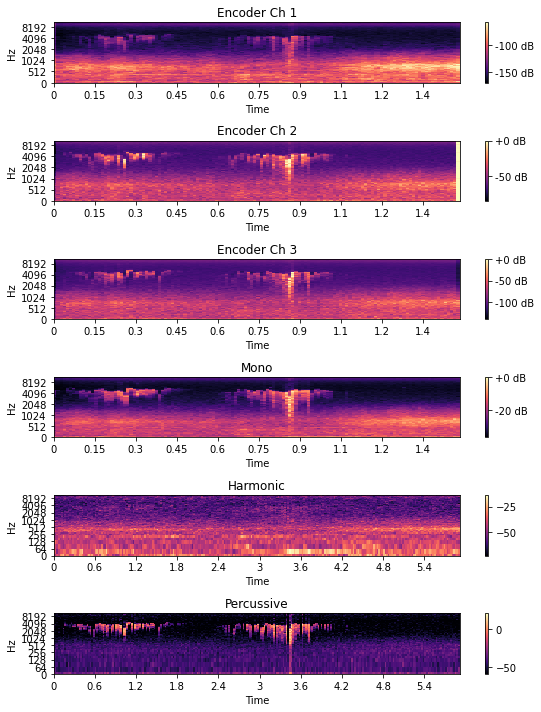

In [3]:
plt.figure(figsize=(8, 10))

filename = ""

Im = torch.load("Dataset_Encoded/2/20200324_232700.pt").squeeze(0).cpu()
plt.subplot(6, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[0,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 1')
plt.tight_layout()

plt.subplot(6, 1, 2)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[1,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 2')
plt.tight_layout()

plt.subplot(6, 1, 3)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im[2,:,:].detach().numpy(),hop_length=512)
plt.title('Encoder Ch 3')
plt.tight_layout()

Im = torch.load("Dataset_Mono/2/20200324_232700.pt")
plt.subplot(6, 1, 4)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plotData(Im.detach().numpy(),hop_length=512)
plt.title('Mono')
plt.tight_layout()

#rp = np.max(Im.detach().numpy())
Im = torch.load("Dataset_HPSS/2/20200324_232700.pt")
Im = Im.detach().numpy()
#rp = np.max(np.abs(Im[0,:,:]))
plt.subplot(6, 1, 5)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[0,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Harmonic')
plt.tight_layout()

plt.subplot(6, 1, 6)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
librosa.display.specshow(librosa.amplitude_to_db(Im[1,:,:]), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive')
plt.tight_layout()